# Team 02 - Assignment 03: Anomaly Prediction FOL Rule Derivation

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Structures](#2-data-structures)
3. [Data Loading Module](#3-data-loading-module)
4. [Data Preprocessing Pipeline](#4-data-preprocessing-pipeline)
5. [Metrics](#5-metrics)
6. [Anomaly Detection](#6-anomaly-detection)
    - [6.1 Rule Based Anomaly Detector](#61-rule-based-anomaly-detector)
    - [6.2 ML-Based Detector (Isolation Forest)](#62-ml-based-detector-isolation-forest)
7. [Load and Process Data](#7-load-and-process-data)
    - [7.1 Anomaly Distribution Analysis](#71-anomaly-distribution-analysis)
8. [Feature Engineering](#8-feature-engineering)
    - [8.1 Map Geometry](#81-map-geometry)
    - [8.2 Computable Functions (F)](#82-computable-functions-f)
    - [8.3 Atomic Relations (R)](#83-atomic-relations-r)
    - [8.4 Feature Extraction Engine](#84-feature-extraction-engine)
    - [8.5 Feature Matrix Generation](#85-feature-matrix-generation)
9. [Decision Tree Anomaly prediction (Baseline Approach)](#9-decision-tree-anomaly-prediction-baseline-approach)
10. [Ensemble Model Anomaly Prediction](#10-ensemble-model-anomaly-prediction)
    - [10.1. Ensemble Model Architecture](#101-ensemble-model-architecture)
    - [10.2 Ensemble Models Training](#102-ensemble-models-training)
11. [Ensemble + Surrogate Tree Approach (current approach)](#11-ensemble--surrogate-tree-approach-current-approach)
    - [11.1 Surrogate Tree Rule Extractor](#111-surrogate-tree-rule-extractor)
    - [11.2 Train Surrogate Trees for Each Anomaly Type](#112-train-surrogate-trees-for-each-anomaly-type)
    - [11.3 Surrogate Tree FOL Rules](#113-surrogate-tree-fol-rules)
    - [11.4 Surrogate Tree Visualization](#114-surrogate-tree-visualization)
    - [11.5 Generalization Analysis](#115-generalization-analysis)
    - [11.6 Feature Importance Heatmap](#116-feature-importance-heatmap-ensemble--surrogate-models)
    - [11.7 Model Comparison: Baseline DT vs Ensemble vs Surrogate](#117-model-comparison-baseline-dt-vs-ensemble-vs-surrogate)

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import ast
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Any
from scipy import interpolate
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

DATASET_PATH = Path('ws25_aia_complete_data')
IMAGES_PATH = Path('images')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# (Important when the notebook uses a dark theme: otherwise axes can look "missing".)
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'white',
    'savefig.transparent': False,
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'grid.color': '#d0d0d0',
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
})

# Ensure inline plots in the notebook have a white background (fixes GitLab dark mode visibility)
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython:
        ipython.run_line_magic('config', "InlineBackend.print_figure_kwargs = {'facecolor' : 'w'}")
except Exception:
    pass

SAVEFIG_KW = dict(facecolor='white', edgecolor='white', transparent=False)

print(f'Dataset path exists: {DATASET_PATH.exists()}')





Dataset path exists: True


## 2. Data Structures

In [2]:
@dataclass
class StaticObject:
    """Static obstacle in the environment."""
    entity_name: str
    position: Tuple[float, float, float]  # x, y, z
    orientation_yaw: float
    dimensions: Tuple[float, float, float]  # width, length, height

@dataclass
class ScenarioConfig:
    """Scenario configuration parameters."""
    goal_poses: List[Dict]
    start_pose: Dict
    laser_noise_std: float
    laser_drop_pct: float
    map_file: str
    static_objects: List['StaticObject'] = field(default_factory=list)

@dataclass
class AMCLData:
    """AMCL localization data from rosbag2.csv."""
    timestamps: np.ndarray  # seconds
    positions: np.ndarray   # (N, 3) x, y, z
    orientations: np.ndarray  # (N, 4) w, x, y, z quaternion
    covariances: List[np.ndarray]  # List of 6x6 covariance matrices

@dataclass
class RunMetrics:
    """Computed metrics for a single run."""
    mean_pos_error: float = 0.0
    rmse_pos: float = 0.0
    mean_yaw_error: float = 0.0
    executed_path_length: float = 0.0
    path_efficiency: float = 0.0
    mean_linear_velocity: float = 0.0
    mean_angular_velocity: float = 0.0
    trajectory_smoothness: float = 0.0
    duration: float = 0.0
    mean_amcl_uncertainty: float = 0.0

@dataclass
class RunData:
    """Complete data for a single simulation run."""
    scenario_name: str
    run_id: int
    run_path: Path
    scenario_category: str = ''
    outcome: str = 'unknown'
    poses_df: Optional[pd.DataFrame] = None
    behaviors_df: Optional[pd.DataFrame] = None
    rosbag_df: Optional[pd.DataFrame] = None  # NEW: rosbag2.csv data
    amcl_data: Optional[AMCLData] = None  # NEW: Parsed AMCL data
    config: Optional[ScenarioConfig] = None
    synced_data: Optional[pd.DataFrame] = None
    metrics: Optional[RunMetrics] = None
    anomalies: List[str] = field(default_factory=list)
    time_series_metrics: Optional[pd.DataFrame] = None
    is_valid: bool = True
    error_msg: str = ''




## 3. Data Loading Module

In [3]:
class DatasetLoader:
    """Handles loading and parsing of all dataset files including rosbag2.csv."""
    
    CATEGORY_PATTERNS = {
        'door-width': r'door-width|door-size',
        'room-size': r'room-size',
        'hallway-window': r'hallway-window',
        'everything-failure': r'everything-failure',
        'floorplan-failure': r'floorplan-failure'
    }
    
    def __init__(self, dataset_path: Path):
        self.dataset_path = dataset_path
        
    def get_scenario_category(self, scenario_name: str) -> str:
        import re
        for cat, pattern in self.CATEGORY_PATTERNS.items():
            if re.search(pattern, scenario_name, re.IGNORECASE):
                return cat
        return 'other'
    
    def parse_static_objects(self, static_objs_data: List[Dict]) -> List[StaticObject]:
        """Parse static objects from scenario config."""
        objects = []
        if not static_objs_data:
            return objects
        for obj in static_objs_data:
            try:
                spawn_pose = obj.get('spawn_pose', {})
                pos = spawn_pose.get('position', {})
                ori = spawn_pose.get('orientation', {})
                # Parse xacro_arguments (e.g., 'width:=0.5, length:=0.5, height:=1.0')
                xacro = obj.get('xacro_arguments', '')
                dims = {'width': 0.5, 'length': 0.5, 'height': 1.0}
                if xacro:
                    for part in xacro.split(','):
                        if ':=' in part:
                            k, v = part.strip().split(':=')
                            dims[k.strip()] = float(v.strip())
                objects.append(StaticObject(
                    entity_name=obj.get('entity_name', 'unknown'),
                    position=(float(pos.get('x', 0)), float(pos.get('y', 0)), float(pos.get('z', 0))),
                    orientation_yaw=float(ori.get('yaw', 0)),
                    dimensions=(dims['width'], dims['length'], dims['height'])
                ))
            except Exception:
                continue
        return objects
    
    def parse_scenario_config(self, config_path: Path) -> Optional[ScenarioConfig]:
        try:
            with open(config_path, 'r') as f:
                data = yaml.safe_load(f)
            ts = data.get('test_scenario', {})
            static_objs = self.parse_static_objects(ts.get('static_objects', []))
            return ScenarioConfig(
                goal_poses=ts.get('goal_poses', []),
                start_pose=ts.get('start_pose', {}),
                laser_noise_std=float(ts.get('laserscan_gaussian_noise_std_deviation', 0.02)),
                laser_drop_pct=float(ts.get('laserscan_random_drop_percentage', 0.0)),
                map_file=ts.get('map_file', ''),
                static_objects=static_objs
            )
        except Exception:
            return None
    
    def parse_amcl_data(self, rosbag_df: pd.DataFrame) -> Optional[AMCLData]:
        """Extract AMCL pose data with uncertainty from rosbag2.csv."""
        if rosbag_df is None or rosbag_df.empty:
            return None
        amcl_rows = rosbag_df[rosbag_df['topic'] == '/amcl_pose']
        if amcl_rows.empty:
            return None
        try:
            timestamps = (amcl_rows['timestamp'].values / 1e9).astype(float)
            positions = np.column_stack([
                amcl_rows['pose.pose.position.x'].values,
                amcl_rows['pose.pose.position.y'].values,
                amcl_rows['pose.pose.position.z'].fillna(0).values
            ])
            orientations = np.column_stack([
                amcl_rows['pose.pose.orientation.w'].values,
                amcl_rows['pose.pose.orientation.x'].values,
                amcl_rows['pose.pose.orientation.y'].values,
                amcl_rows['pose.pose.orientation.z'].values
            ])
            # Parse covariance matrices with improved handling
            covariances = []
            for cov_val in amcl_rows['pose.covariance'].values:
                try:
                    if cov_val is None or (isinstance(cov_val, float) and np.isnan(cov_val)):
                        covariances.append(np.eye(6) * 0.01)
                        continue
                    
                    if isinstance(cov_val, str):
                        # Clean string and parse
                        cov_str = cov_val.replace('\n', ' ').replace('[', '').replace(']', '')
                        cov_arr = np.fromstring(cov_str, sep=' ')
                        if len(cov_arr) != 36:
                            # Try comma separation
                            cov_arr = np.fromstring(cov_str, sep=',')
                        if len(cov_arr) != 36:
                            # Try ast.literal_eval as fallback
                            cov_arr = np.array(ast.literal_eval(cov_val.replace('\n', ' ')))
                    elif isinstance(cov_val, (list, np.ndarray)):
                        cov_arr = np.array(cov_val).flatten()
                    else:
                        covariances.append(np.eye(6) * 0.01)
                        continue
                    
                    if len(cov_arr) == 36:
                        cov_matrix = cov_arr.reshape(6, 6)
                        # Validate: covariance diagonal should be non-negative
                        if np.all(np.diag(cov_matrix) >= 0):
                            covariances.append(cov_matrix)
                        else:
                            covariances.append(np.eye(6) * 0.01)
                    else:
                        covariances.append(np.eye(6) * 0.01)
                except Exception:
                    covariances.append(np.eye(6) * 0.01)
            
            return AMCLData(timestamps=timestamps, positions=positions, 
                           orientations=orientations, covariances=covariances)
        except Exception as e:
            return None
    
    def get_run_outcome(self, behaviors_df: pd.DataFrame) -> str:
        if behaviors_df is None or behaviors_df.empty:
            return 'no_data'
        nav = behaviors_df[behaviors_df['behavior_name'].str.contains('nav_through_poses', na=False)]
        if nav.empty:
            return 'no_navigation'
        last_status = nav.iloc[-1]['status_name']
        return 'success' if last_status == 'SUCCESS' else ('failure' if last_status == 'FAILURE' else 'incomplete')
    
    def load_run(self, run_path: Path, scenario_name: str, run_id: int) -> RunData:
        run = RunData(scenario_name=scenario_name, run_id=run_id, run_path=run_path,
                      scenario_category=self.get_scenario_category(scenario_name))
        # Load poses.csv
        poses_path = run_path / 'poses.csv'
        if poses_path.exists():
            try:
                run.poses_df = pd.read_csv(poses_path)
                if run.poses_df.empty:
                    run.is_valid = False
                    run.error_msg = 'Empty poses.csv'
            except Exception as e:
                run.is_valid = False
                run.error_msg = f'Poses error: {e}'
        else:
            run.is_valid = False
            run.error_msg = 'Missing poses.csv'
        # Load behaviors.csv
        behaviors_path = run_path / 'behaviors.csv'
        if behaviors_path.exists():
            try:
                run.behaviors_df = pd.read_csv(behaviors_path)
            except Exception:
                pass
        # Load rosbag2.csv (NEW)
        rosbag_path = run_path / 'rosbag2.csv'
        if rosbag_path.exists():
            try:
                run.rosbag_df = pd.read_csv(rosbag_path, low_memory=False)
                run.amcl_data = self.parse_amcl_data(run.rosbag_df)
            except Exception:
                pass
        # Load config
        config_path = run_path / 'scenario.config'
        if config_path.exists():
            run.config = self.parse_scenario_config(config_path)
        run.outcome = self.get_run_outcome(run.behaviors_df)
        return run
    
    def load_all_runs(self, max_scenarios: int = None) -> List[RunData]:
        runs = []
        scenario_dirs = sorted([d for d in self.dataset_path.iterdir() if d.is_dir()])
        if max_scenarios:
            scenario_dirs = scenario_dirs[:max_scenarios]
        for scenario_dir in tqdm(scenario_dirs, desc='Loading scenarios'):
            scenario_name = scenario_dir.name
            run_dirs = sorted([d for d in scenario_dir.iterdir() if d.is_dir() and d.name.isdigit()])
            for run_dir in run_dirs:
                run = self.load_run(run_dir, scenario_name, int(run_dir.name))
                runs.append(run)
        return runs

loader = DatasetLoader(DATASET_PATH)
print('Loader initialized with rosbag2 support')




Loader initialized with rosbag2 support


## 4. Data Preprocessing Pipeline

In [4]:
class DataPreprocessor:
    """Handles data synchronization and preprocessing."""
    
    @staticmethod
    def normalize_yaw(yaw: np.ndarray) -> np.ndarray:
        return np.arctan2(np.sin(yaw), np.cos(yaw))
    
    @staticmethod
    def quaternion_to_yaw(w, x, y, z):
        """Convert quaternion to yaw angle."""
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        return np.arctan2(siny_cosp, cosy_cosp)
    
    @staticmethod
    def sync_poses(poses_df: pd.DataFrame) -> Optional[pd.DataFrame]:
        if poses_df is None or poses_df.empty:
            return None
        gt_df = poses_df[poses_df['frame'] == 'nav2_turtlebot4_base_link_gt'].copy()
        est_df = poses_df[poses_df['frame'] == 'base_link'].copy()
        if gt_df.empty or est_df.empty:
            return None
        gt_df = gt_df.sort_values('timestamp').drop_duplicates('timestamp')
        est_df = est_df.sort_values('timestamp').drop_duplicates('timestamp')
        est_times = est_df['timestamp'].values
        gt_times = gt_df['timestamp'].values
        if len(gt_times) < 2:
            return None
        valid_mask = (est_times >= gt_times.min()) & (est_times <= gt_times.max())
        est_df = est_df[valid_mask]
        if len(est_df) < 2:
            return None
        synced = est_df.copy()
        synced = synced.rename(columns={'position.x': 'est_x', 'position.y': 'est_y', 'orientation.yaw': 'est_yaw'})
        for col, new_col in [('position.x', 'gt_x'), ('position.y', 'gt_y'), ('orientation.yaw', 'gt_yaw')]:
            f = interpolate.interp1d(gt_times, gt_df[col].values, kind='linear', fill_value='extrapolate')
            synced[new_col] = f(synced['timestamp'].values)
        synced['gt_yaw'] = DataPreprocessor.normalize_yaw(synced['gt_yaw'].values)
        synced['est_yaw'] = DataPreprocessor.normalize_yaw(synced['est_yaw'].values)
        synced = synced[['timestamp', 'est_x', 'est_y', 'est_yaw', 'gt_x', 'gt_y', 'gt_yaw']]
        return synced.reset_index(drop=True)
    
    @staticmethod
    def filter_stationary(synced_df: pd.DataFrame, velocity_threshold: float = 0.01) -> pd.DataFrame:
        if synced_df is None or len(synced_df) < 3:
            return synced_df
        dx = np.diff(synced_df['est_x'].values)
        dy = np.diff(synced_df['est_y'].values)
        dt = np.diff(synced_df['timestamp'].values)
        dt = np.where(dt == 0, 1e-6, dt)
        velocity = np.sqrt(dx**2 + dy**2) / dt
        velocity = np.concatenate([[velocity[0]], velocity])
        moving_mask = velocity > velocity_threshold
        first_moving = np.argmax(moving_mask)
        last_moving = len(moving_mask) - np.argmax(moving_mask[::-1]) - 1
        return synced_df.iloc[first_moving:last_moving+1].reset_index(drop=True)
    
    def preprocess(self, run: RunData, filter_stationary: bool = True) -> RunData:
        if not run.is_valid:
            return run
        synced = self.sync_poses(run.poses_df)
        if synced is None or len(synced) < 10:
            run.is_valid = False
            run.error_msg = 'Sync failed'
            return run
        if filter_stationary:
            synced = self.filter_stationary(synced)
        if synced is None or len(synced) < 5:
            run.is_valid = False
            run.error_msg = 'Too few points after filtering'
            return run
        run.synced_data = synced
        return run

preprocessor = DataPreprocessor()
print('Preprocessor initialized')




Preprocessor initialized


## 5. Metrics

In [5]:
class MetricCalculator:
    """Computes performance metrics including AMCL uncertainty."""
    
    @staticmethod
    def compute_position_error(synced: pd.DataFrame) -> np.ndarray:
        return np.sqrt((synced['est_x'] - synced['gt_x'])**2 + (synced['est_y'] - synced['gt_y'])**2)
    
    @staticmethod
    def compute_yaw_error(synced: pd.DataFrame) -> np.ndarray:
        diff = synced['est_yaw'] - synced['gt_yaw']
        return np.abs(np.arctan2(np.sin(diff), np.cos(diff)))
    
    @staticmethod
    def compute_path_length(x: np.ndarray, y: np.ndarray) -> float:
        return float(np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2)))
    
    @staticmethod
    def compute_velocities(synced: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        t = synced['timestamp'].values
        dt = np.diff(t)
        dt = np.where(dt == 0, 1e-6, dt)
        dx = np.diff(synced['est_x'].values)
        dy = np.diff(synced['est_y'].values)
        dyaw = np.diff(synced['est_yaw'].values)
        dyaw = np.arctan2(np.sin(dyaw), np.cos(dyaw))
        linear_vel = np.sqrt(dx**2 + dy**2) / dt
        angular_vel = np.abs(dyaw) / dt
        return linear_vel, angular_vel
    
    @staticmethod
    def compute_trajectory_smoothness(angular_vel: np.ndarray, dt: np.ndarray) -> float:
        if len(angular_vel) < 2:
            return 0.0
        dt_safe = np.where(dt[:-1] == 0, 1e-6, dt[:-1]) if len(dt) > len(angular_vel)-1 else dt
        angular_acc = np.diff(angular_vel) / dt_safe[:len(angular_vel)-1]
        return float(np.mean(np.abs(angular_acc)))
    
    @staticmethod
    def compute_amcl_uncertainty(amcl_data: Optional[AMCLData]) -> float:
        """Compute mean positional uncertainty from AMCL covariance.
        
        Uses sqrt of sum of x,y variances (diagonal elements 0,0 and 1,1).
        This represents the 1-sigma positional uncertainty ellipse size.
        """
        if amcl_data is None or not amcl_data.covariances:
            return 0.0
        
        uncertainties = []
        for cov in amcl_data.covariances:
            try:
                if cov is None or not isinstance(cov, np.ndarray):
                    continue
                if cov.shape != (6, 6):
                    continue
                
                # Extract x and y variances (diagonal elements)
                var_x = cov[0, 0]
                var_y = cov[1, 1]
                
                # Skip invalid values
                if not (np.isfinite(var_x) and np.isfinite(var_y)):
                    continue
                if var_x < 0 or var_y < 0:
                    continue
                
                # Positional uncertainty: sqrt of sum of variances
                # This is the "circular error probable" approximation
                pos_uncertainty = np.sqrt(var_x + var_y)
                
                # Additional sanity check: uncertainty should be reasonable (< 100m)
                if pos_uncertainty < 100.0:
                    uncertainties.append(pos_uncertainty)
            except Exception:
                continue
        
        if not uncertainties:
            return 0.0
        
        return float(np.mean(uncertainties))
    
    def compute_time_series(self, synced: pd.DataFrame) -> pd.DataFrame:
        pos_error = self.compute_position_error(synced)
        yaw_error = self.compute_yaw_error(synced)
        linear_vel, angular_vel = self.compute_velocities(synced)
        ts = pd.DataFrame({
            'timestamp': synced['timestamp'].values,
            'pos_error': pos_error,
            'yaw_error': yaw_error
        })
        ts['linear_vel'] = np.concatenate([[linear_vel[0]], linear_vel])
        ts['angular_vel'] = np.concatenate([[angular_vel[0]], angular_vel])
        return ts
    
    def compute_metrics(self, run: RunData) -> RunData:
        if not run.is_valid or run.synced_data is None:
            return run
        synced = run.synced_data
        pos_error = self.compute_position_error(synced)
        yaw_error = self.compute_yaw_error(synced)
        linear_vel, angular_vel = self.compute_velocities(synced)
        executed_path = self.compute_path_length(synced['est_x'].values, synced['est_y'].values)
        gt_path = self.compute_path_length(synced['gt_x'].values, synced['gt_y'].values)
        dt = np.diff(synced['timestamp'].values)
        mean_amcl = self.compute_amcl_uncertainty(run.amcl_data)
        run.metrics = RunMetrics(
            mean_pos_error=float(np.mean(pos_error)),
            rmse_pos=float(np.sqrt(np.mean(pos_error**2))),
            mean_yaw_error=float(np.mean(yaw_error)),
            executed_path_length=executed_path,
            path_efficiency=gt_path / executed_path if executed_path > 0 else 0,
            mean_linear_velocity=float(np.mean(linear_vel)),
            mean_angular_velocity=float(np.mean(angular_vel)),
            trajectory_smoothness=self.compute_trajectory_smoothness(angular_vel, dt),
            duration=float(synced['timestamp'].iloc[-1] - synced['timestamp'].iloc[0]),
            mean_amcl_uncertainty=mean_amcl
        )
        run.time_series_metrics = self.compute_time_series(synced)
        return run

metric_calculator = MetricCalculator()
print('Metric calculator initialized with AMCL uncertainty')


Metric calculator initialized with AMCL uncertainty


## 6. Anomaly Detection

### 6.1 Rule Based Anomaly Detector

In [6]:
class RuleBasedAnomalyDetector:
    """Rule-based anomaly detection using multiple data sources."""
    
    def __init__(self, pos_error_sigma: float = 3.0, consecutive_frames: int = 3):
        self.pos_error_sigma = pos_error_sigma
        self.consecutive_frames = consecutive_frames
        self.global_pos_error_stats = None
    
    def compute_global_stats(self, runs: List[RunData]):
        all_errors = []
        for run in runs:
            if run.is_valid and run.time_series_metrics is not None:
                all_errors.extend(run.time_series_metrics['pos_error'].values)
        if all_errors:
            self.global_pos_error_stats = {'mean': np.mean(all_errors), 'std': np.std(all_errors)}
    
    def detect_goal_failure(self, run: RunData) -> bool:
        return run.outcome == 'failure'
    
    def detect_position_error_spike(self, run: RunData) -> bool:
        if not run.is_valid or run.time_series_metrics is None or self.global_pos_error_stats is None:
            return False
        threshold = self.global_pos_error_stats['mean'] + self.pos_error_sigma * self.global_pos_error_stats['std']
        errors = run.time_series_metrics['pos_error'].values
        above_threshold = errors > threshold
        for i in range(len(above_threshold) - self.consecutive_frames + 1):
            if all(above_threshold[i:i+self.consecutive_frames]):
                return True
        return False
    
    def detect_stuck(self, run: RunData, velocity_threshold: float = 0.01, duration_threshold: float = 5.0) -> bool:
        if not run.is_valid or run.time_series_metrics is None:
            return False
        ts = run.time_series_metrics
        stuck_mask = ts['linear_vel'] < velocity_threshold
        start = None
        for i, is_stuck in enumerate(stuck_mask):
            if is_stuck and start is None:
                start = ts['timestamp'].iloc[i]
            elif not is_stuck and start is not None:
                duration = ts['timestamp'].iloc[i] - start
                if duration > duration_threshold:
                    return True
                start = None
        return False
    
    def detect_high_amcl_uncertainty(self, run: RunData, threshold: float = 0.5) -> bool:
        """Detect high localization uncertainty from AMCL."""
        if run.metrics is None:
            return False
        return run.metrics.mean_amcl_uncertainty > threshold
    
    def detect_high_yaw_error(self, run: RunData, threshold: float = 0.5) -> bool:
        return run.metrics.mean_yaw_error > threshold if run.metrics else False

    def detect_path_inefficiency(self, run: RunData, threshold: float = 0.6) -> bool:
        return run.metrics.path_efficiency < threshold if run.metrics else False
    
    def detect_all(self, run: RunData) -> List[str]:
        anomalies = []
        if self.detect_goal_failure(run):
            anomalies.append('goal_failure')
        if self.detect_position_error_spike(run):
            anomalies.append('position_error_spike')
        if self.detect_stuck(run):
            anomalies.append('stuck')
        if self.detect_high_amcl_uncertainty(run):
            anomalies.append('high_amcl_uncertainty')
        if self.detect_high_yaw_error(run):
            anomalies.append('high_yaw_error')
        if self.detect_path_inefficiency(run):
            anomalies.append('path_inefficiency')
        return anomalies

### 6.2 ML-Based Detector (Isolation Forest)

In [7]:
class MLAnomalyDetector:
    """ML-based anomaly detection using Isolation Forest."""
    
    def __init__(self, contamination: float = 0.1):
        self.contamination = contamination
        self.model = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
        self.scaler = StandardScaler()
        self.is_fitted = False
    
    def extract_features(self, run: RunData) -> Optional[np.ndarray]:
        if not run.is_valid or run.metrics is None:
            return None
        m = run.metrics
        return np.array([
            m.mean_pos_error, m.rmse_pos, m.mean_yaw_error,
            m.executed_path_length, m.duration, m.path_efficiency,
            m.mean_linear_velocity, m.trajectory_smoothness,
            m.mean_amcl_uncertainty
        ])
    
    def fit(self, runs: List[RunData]):
        features = [self.extract_features(r) for r in runs if r.is_valid and r.metrics is not None]
        features = [f for f in features if f is not None]
        if len(features) < 10:
            return
        X = np.vstack(features)
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled)
        self.is_fitted = True
    
    def predict(self, run: RunData) -> bool:
        if not self.is_fitted:
            return False
        features = self.extract_features(run)
        if features is None:
            return False
        X_scaled = self.scaler.transform(features.reshape(1, -1))
        return self.model.predict(X_scaled)[0] == -1

rule_detector = RuleBasedAnomalyDetector()
ml_detector = MLAnomalyDetector(contamination=0.15)
print('Anomaly detectors initialized with AMCL-based detection')

Anomaly detectors initialized with AMCL-based detection


## 7. Load and Process Data

In [8]:
# Load all runs
print('Loading dataset (this may take a few minutes)...')
all_runs = loader.load_all_runs(max_scenarios=100)  # Set to e.g. 50 for faster processing
print(f'Loaded {len(all_runs)} total runs')

# Count runs with rosbag data
runs_with_rosbag = sum(1 for r in all_runs if r.rosbag_df is not None)
runs_with_amcl = sum(1 for r in all_runs if r.amcl_data is not None)
print(f'Runs with rosbag2.csv: {runs_with_rosbag}')
print(f'Runs with parsed AMCL data: {runs_with_amcl}')

# Preprocess
print('\nPreprocessing...')
for run in tqdm(all_runs, desc='Preprocessing'):
    preprocessor.preprocess(run)

valid_runs = [r for r in all_runs if r.is_valid]
print(f'Valid runs after preprocessing: {len(valid_runs)}')

# Compute metrics
print('\nComputing metrics...')
for run in tqdm(valid_runs, desc='Computing metrics'):
    metric_calculator.compute_metrics(run)

# Anomaly detection
print('\nDetecting anomalies...')
rule_detector.compute_global_stats(valid_runs)
ml_detector.fit(valid_runs)

for run in valid_runs:
    run.anomalies = rule_detector.detect_all(run)
    if ml_detector.predict(run):
        run.anomalies.append('Isolation Forest')

print('\n✅ Processing complete!')

Loading dataset (this may take a few minutes)...


Loading scenarios:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded 300 total runs
Runs with rosbag2.csv: 300
Runs with parsed AMCL data: 300

Preprocessing...


Preprocessing:   0%|          | 0/300 [00:00<?, ?it/s]

Valid runs after preprocessing: 300

Computing metrics...


Computing metrics:   0%|          | 0/300 [00:00<?, ?it/s]


Detecting anomalies...

✅ Processing complete!


### 7.1 Anomaly Distribution Analysis

All nine anomalies are represented in the data.


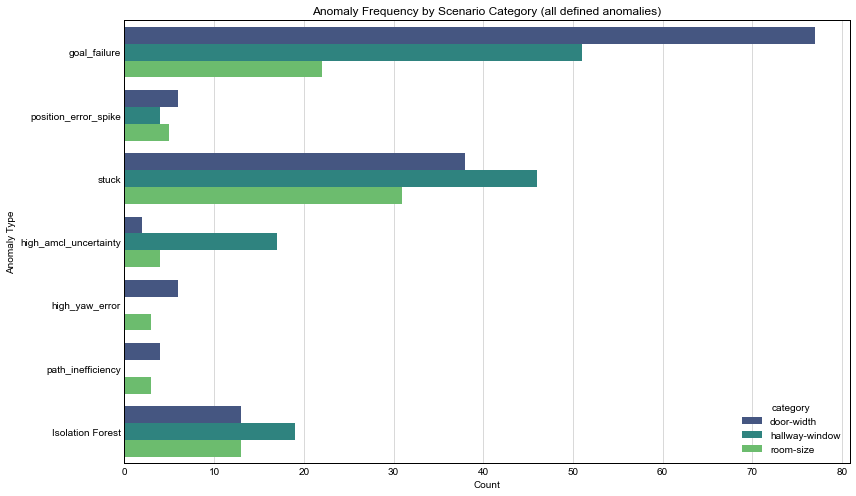

In [9]:
# 7.2 Anomaly distribution by category
ANOM_LABELS = [
    'goal_failure',
    'position_error_spike',
    'stuck',
    'high_amcl_uncertainty',
    'high_yaw_error',
    'path_inefficiency',
    'Isolation Forest'
]

anomaly_data = []
for run in valid_runs:
    for a in run.anomalies:
        anomaly_data.append({'category': run.scenario_category, 'anomaly': a})

if anomaly_data:
    df_anom = pd.DataFrame(anomaly_data)
    categories = sorted(df_anom['category'].unique())
    df_counts = df_anom.value_counts(['anomaly', 'category']).reset_index(name='count')

    # ensure every anomaly/category combo exists (zero if missing)
    grid = pd.DataFrame(
        [{'anomaly': a, 'category': c} for a in ANOM_LABELS for c in categories]
    )
    df_counts = (grid.merge(df_counts, on=['anomaly', 'category'], how='left')
                       .fillna({'count': 0}))

    missing_anoms = [a for a in ANOM_LABELS if df_counts[df_counts['anomaly'] == a]['count'].sum() == 0]
    if missing_anoms:
        print('Anomalies with zero occurrences (reason: not triggered in any run):', missing_anoms)
    else:
        print('All nine anomalies are represented in the data.')

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(data=df_counts, y='anomaly', x='count', hue='category', ax=ax, palette='viridis')
    ax.set_title('Anomaly Frequency by Scenario Category (all defined anomalies)')
    ax.set_xlabel('Count')
    ax.set_ylabel('Anomaly Type')
    plt.tight_layout()
    plt.savefig(IMAGES_PATH / 'anomaly_by_category.png', dpi=150, **SAVEFIG_KW)
    plt.show()
else:
    print('No anomalies detected to plot.')

## 8. Feature Engineering



In [10]:
import json
from shapely.geometry import Point, Polygon, LineString
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Robot Constants
ROBOT_FOOTPRINT = 0.22  # TurtleBot4 diameter in meters
ROBOT_RADIUS = ROBOT_FOOTPRINT / 2
SENSOR_HEIGHT = 0.20  # LiDAR sensor height from ground (20cm)

print(f'Robot Constants: Footprint={ROBOT_FOOTPRINT}m, Sensor Height={SENSOR_HEIGHT}m')

Robot Constants: Footprint=0.22m, Sensor Height=0.2m


### 8.1 Map Geometry
Integrate map geometry from `maps_details.json` and define causal features for anomaly rule derivation.

In [11]:
class MapGeometry:
    """Loads and provides geometric queries for map features."""
    
    def __init__(self, maps_details_path: Path):
        with open(maps_details_path, 'r') as f:
            self.data = json.load(f)
        self.maps = {}
        self._parse_maps()
        
    def _parse_maps(self):
        for map_info in self.data['maps']:
            map_name = map_info['map']
            spaces = {}
            for space in map_info['spaces']:
                space_name = space['space_name']
                corners = space['corners']
                door = space.get('door', [])
                polygon = Polygon(corners) if len(corners) >= 3 else None
                door_line = LineString(door) if len(door) == 2 else None
                door_width = door_line.length if door_line else 0.0
                spaces[space_name] = {
                    'polygon': polygon, 'corners': corners,
                    'door_line': door_line, 'door_width': door_width,
                    'door_center': door_line.centroid if door_line else None
                }
            self.maps[map_name] = spaces
    
    def get_map_for_scenario(self, scenario_name: str) -> Optional[dict]:
        scenario_lower = scenario_name.lower()
        mapping = {
            '0.3 door': '0-3-door', '0.33 door': '0-33-door', '0.36 door': '0-36-door',
            '0.44 door': '0-44-door', '0.47 door': '0-47-door', 'door_size_0.5': 'door-size-0-5',
            'hallway_window': 'hallway-window', 'room_size_less_50': 'room-size-less-50'
        }
        for map_name, spaces in self.maps.items():
            for key, pattern in mapping.items():
                if key in map_name.lower() and pattern in scenario_lower:
                    return spaces
        return list(self.maps.values())[0] if self.maps else None
    
    def get_corridor_width(self, spaces: dict) -> float:
        if 'corridor' in spaces and spaces['corridor']['polygon']:
            bounds = spaces['corridor']['polygon'].bounds
            return min(bounds[2] - bounds[0], bounds[3] - bounds[1])
        return 1.67
    
    def get_min_door_width(self, spaces: dict) -> float:
        widths = [s['door_width'] for s in spaces.values() if s['door_width'] > 0]
        return min(widths) if widths else 1.0

MAP_GEOMETRY = MapGeometry(Path('maps_details.json'))
print(f'Loaded {len(MAP_GEOMETRY.maps)} maps')

Loaded 10 maps


### 8.2 Computable Functions (F)

In [12]:
class ComputableFunctions:
    """Computable functions F - distances, areas, clearances."""
    
    def __init__(self, map_geometry: MapGeometry):
        self.map_geometry = map_geometry
    
    def distance_to_closest_wall(self, x: float, y: float, spaces: dict) -> float:
        point = Point(x, y)
        min_dist = float('inf')
        for space_info in spaces.values():
            if space_info['polygon']:
                min_dist = min(min_dist, point.distance(space_info['polygon'].exterior))
        return min_dist if min_dist != float('inf') else 0.5
    
    def distance_to_closest_door(self, x: float, y: float, spaces: dict) -> Tuple[float, str]:
        point = Point(x, y)
        min_dist, closest_room = float('inf'), None
        for space_name, space_info in spaces.items():
            if space_info['door_center']:
                dist = point.distance(space_info['door_center'])
                if dist < min_dist:
                    min_dist, closest_room = dist, space_name
        return (min_dist if min_dist != float('inf') else 10.0, closest_room)
    
    def door_width_at_location(self, x: float, y: float, spaces: dict) -> float:
        dist, room = self.distance_to_closest_door(x, y, spaces)
        return spaces[room]['door_width'] if room and dist < 1.0 else 1.0
    
    def get_current_room(self, x: float, y: float, spaces: dict) -> Optional[str]:
        point = Point(x, y)
        for space_name, space_info in spaces.items():
            if space_info['polygon'] and space_info['polygon'].contains(point):
                return space_name
        return None
    
    def room_area(self, room_name: str, spaces: dict) -> float:
        if room_name and room_name in spaces and spaces[room_name]['polygon']:
            return spaces[room_name]['polygon'].area
        return 20.0
    
    def goal_to_wall_distance(self, gx: float, gy: float, spaces: dict) -> float:
        return self.distance_to_closest_wall(gx, gy, spaces)
    
    def path_crosses_door(self, sx, sy, gx, gy, spaces: dict) -> bool:
        path = LineString([(sx, sy), (gx, gy)])
        return any(s['door_line'] and path.intersects(s['door_line']) for s in spaces.values())
    
    # === Static Object (Obstacle) Functions ===
    
    def distance_to_closest_obstacle(self, x: float, y: float, static_objects: List[StaticObject]) -> float:
        """Compute distance to the closest static obstacle center."""
        if not static_objects:
            return float('inf')
        return min(np.sqrt((x - obj.position[0])**2 + (y - obj.position[1])**2) 
                   for obj in static_objects)
    
    def obstacle_clearance_ratio(self, x: float, y: float, static_objects: List[StaticObject]) -> float:
        """Ratio of distance to closest obstacle vs robot radius."""
        dist = self.distance_to_closest_obstacle(x, y, static_objects)
        return dist / ROBOT_RADIUS if dist != float('inf') else 10.0
    
    def path_passes_near_obstacle(self, trajectory_x, trajectory_y, static_objects: List[StaticObject], 
                                   threshold: float = 0.5) -> bool:
        """Check if trajectory passes within threshold of any obstacle."""
        if not static_objects:
            return False
        for x, y in zip(trajectory_x, trajectory_y):
            if self.distance_to_closest_obstacle(x, y, static_objects) < threshold:
                return True
        return False

FUNCTIONS = ComputableFunctions(MAP_GEOMETRY)
print('Computable functions initialized with obstacle support')

Computable functions initialized with obstacle support


### 8.3 Atomic Relations (R)

In [13]:
class AtomicRelations:
    """Boolean predicates R based on causal features."""
    
    def __init__(self, functions: ComputableFunctions, footprint: float = ROBOT_FOOTPRINT):
        self.F = functions
        self.footprint = footprint
    
    def near_wall(self, x, y, spaces): 
        return self.F.distance_to_closest_wall(x, y, spaces) < self.footprint * 1.5
    def at_door(self, x, y, spaces): 
        return self.F.distance_to_closest_door(x, y, spaces)[0] < 0.5
    def door_too_narrow(self, x, y, spaces): 
        return self.F.door_width_at_location(x, y, spaces) < self.footprint * 1.8
    def in_narrow_corridor(self, spaces): 
        return self.F.map_geometry.get_corridor_width(spaces) < self.footprint * 3
    def in_small_room(self, x, y, spaces):
        room = self.F.get_current_room(x, y, spaces)
        return self.F.room_area(room, spaces) < 5.0 if room else False
    def tight_clearance(self, x, y, spaces): 
        return self.F.distance_to_closest_wall(x, y, spaces) < self.footprint * 1.2
    def in_corridor(self, x, y, spaces): 
        return self.F.get_current_room(x, y, spaces) == 'corridor'
    def goal_near_wall(self, gx, gy, spaces): 
        return self.F.goal_to_wall_distance(gx, gy, spaces) < self.footprint
    def goal_through_door(self, sx, sy, gx, gy, spaces): 
        return self.F.path_crosses_door(sx, sy, gx, gy, spaces)
    def waypoint_in_tight_space(self, gx, gy, spaces): 
        return self.F.distance_to_closest_wall(gx, gy, spaces) < self.footprint * 1.5
    def high_noise(self, noise): 
        return noise > 0.05
    def min_door_narrow(self, spaces): 
        return self.F.map_geometry.get_min_door_width(spaces) < self.footprint * 1.8
    
    # === Static Object (Obstacle) Predicates ===
    
    def near_static_obstacle(self, x, y, static_objects, threshold=0.5):
        """True if position is near a static obstacle."""
        return self.F.distance_to_closest_obstacle(x, y, static_objects) < threshold
    
    def tight_obstacle_clearance(self, x, y, static_objects):
        """True if clearance to obstacle is less than 1.5x robot footprint."""
        dist = self.F.distance_to_closest_obstacle(x, y, static_objects)
        return dist < self.footprint * 1.5 if dist != float('inf') else False
    
    def has_static_obstacles(self, static_objects):
        """True if scenario has any static obstacles."""
        return len(static_objects) > 0

RELATIONS = AtomicRelations(FUNCTIONS)
print('Atomic relations initialized: 15 causal predicates (12 map + 3 obstacle)')

Atomic relations initialized: 15 causal predicates (12 map + 3 obstacle)


### 8.4 Feature Extraction Engine

In [14]:
class FeatureExtractor:
    """Extract feature vectors for anomaly rule derivation."""
    
    FEATURE_NAMES = [
        # Map-based features (8 continuous)
        'min_wall_distance', 'min_door_distance', 'door_width', 'corridor_width',
        'room_area', 'clearance_ratio', 'goal_wall_distance', 'noise_level',
        # Boolean predicates (12)
        'near_wall', 'at_door', 'door_too_narrow', 'in_narrow_corridor', 'in_small_room',
        'tight_clearance', 'in_corridor', 'goal_near_wall', 'goal_through_door',
        'waypoint_in_tight_space', 'high_noise', 'min_door_narrow',
        # Obstacle-derived features (4 continuous + 3 boolean = 7 new)
        'min_obstacle_distance', 'obstacle_clearance_ratio', 'num_obstacles', 'total_obstacle_area',
        'near_static_obstacle', 'tight_obstacle_clearance', 'has_static_obstacles'
    ]
    
    def __init__(self, map_geometry, relations, functions):
        self.map_geometry, self.R, self.F = map_geometry, relations, functions
    
    def extract_features(self, run: RunData) -> Optional[np.ndarray]:
        if not run.is_valid or run.synced_data is None or run.config is None:
            return None
        spaces = self.map_geometry.get_map_for_scenario(run.scenario_name)
        if not spaces: return None
        
        synced, config = run.synced_data, run.config
        mean_x, mean_y = synced['gt_x'].mean(), synced['gt_y'].mean()
        goals = config.goal_poses
        goal_x = goals[-1].get('position', {}).get('x', 0) if goals else mean_x
        goal_y = goals[-1].get('position', {}).get('y', 0) if goals else mean_y
        start_x = config.start_pose.get('position', {}).get('x', 0)
        start_y = config.start_pose.get('position', {}).get('y', 0)
        noise = config.laser_noise_std
        
        # Get static objects from config
        static_objects = config.static_objects if hasattr(config, 'static_objects') else []
        
        # Map-based features
        min_wall = self.F.distance_to_closest_wall(mean_x, mean_y, spaces)
        min_door, _ = self.F.distance_to_closest_door(mean_x, mean_y, spaces)
        door_w = self.F.door_width_at_location(mean_x, mean_y, spaces)
        corr_w = self.map_geometry.get_corridor_width(spaces)
        room = self.F.get_current_room(mean_x, mean_y, spaces)
        room_a = self.F.room_area(room, spaces) if room else 20.0
        clearance = min_wall / ROBOT_RADIUS if ROBOT_RADIUS > 0 else 10.0
        goal_wall = self.F.goal_to_wall_distance(goal_x, goal_y, spaces)
        
        # Obstacle-derived continuous features
        min_obs_dist = self.F.distance_to_closest_obstacle(mean_x, mean_y, static_objects)
        min_obs_dist = min_obs_dist if min_obs_dist != float('inf') else 10.0  # Cap at 10m if no obstacles
        obs_clearance = self.F.obstacle_clearance_ratio(mean_x, mean_y, static_objects)
        num_obstacles = len(static_objects)
        total_obs_area = sum(o.dimensions[0] * o.dimensions[1] for o in static_objects) if static_objects else 0.0
        
        return np.array([
            # 8 continuous features
            min_wall, min_door, door_w, corr_w, room_a, clearance, goal_wall, noise,
            # 12 boolean predicates
            int(self.R.near_wall(mean_x, mean_y, spaces)),
            int(self.R.at_door(mean_x, mean_y, spaces)),
            int(self.R.door_too_narrow(mean_x, mean_y, spaces)),
            int(self.R.in_narrow_corridor(spaces)),
            int(self.R.in_small_room(mean_x, mean_y, spaces)),
            int(self.R.tight_clearance(mean_x, mean_y, spaces)),
            int(self.R.in_corridor(mean_x, mean_y, spaces)),
            int(self.R.goal_near_wall(goal_x, goal_y, spaces)),
            int(self.R.goal_through_door(start_x, start_y, goal_x, goal_y, spaces)),
            int(self.R.waypoint_in_tight_space(goal_x, goal_y, spaces)),
            int(self.R.high_noise(noise)),
            int(self.R.min_door_narrow(spaces)),
            # NEW: 4 obstacle continuous + 3 obstacle boolean features
            min_obs_dist, obs_clearance, num_obstacles, total_obs_area,
            int(self.R.near_static_obstacle(mean_x, mean_y, static_objects)),
            int(self.R.tight_obstacle_clearance(mean_x, mean_y, static_objects)),
            int(self.R.has_static_obstacles(static_objects))
        ])

EXTRACTOR = FeatureExtractor(MAP_GEOMETRY, RELATIONS, FUNCTIONS)
print(f'Feature extractor: {len(EXTRACTOR.FEATURE_NAMES)} features (12 continuous + 15 boolean)')

Feature extractor: 27 features (12 continuous + 15 boolean)


### 8.5 Feature Matrix Generation

In [28]:
# Extract features for all runs
print('Extracting features...')
feature_data, labels, run_info = [], [], []

for run in tqdm(valid_runs, desc='Extracting features'):
    features = EXTRACTOR.extract_features(run)
    if features is not None:
        feature_data.append(features)
        labels.append(1 if run.anomalies else 0)
        run_info.append({'scenario': run.scenario_name, 'run_id': run.run_id, 
                        'anomalies': run.anomalies, 'outcome': run.outcome})

X = np.array(feature_data)
y = np.array(labels)
# Track scenarios for rule-level stats
run_scenarios = [r['scenario'] for r in run_info]

print(f'\nExtracted features for {len(X)} runs')
print(f'With anomalies: {sum(y)} ({100*sum(y)/len(y):.1f}%)')

feature_df = pd.DataFrame(X, columns=EXTRACTOR.FEATURE_NAMES)
feature_df['has_anomaly'] = y
feature_df['scenario'] = [r['scenario'] for r in run_info]
feature_df['anomalies'] = [','.join(r['anomalies']) for r in run_info]
print('\nFeature statistics:')
print(feature_df[EXTRACTOR.FEATURE_NAMES].describe().round(3))




Extracting features...


Extracting features:   0%|          | 0/300 [00:00<?, ?it/s]


Extracted features for 300 runs
With anomalies: 221 (73.7%)

Feature statistics:
       min_wall_distance  min_door_distance  door_width  corridor_width  \
count            300.000            300.000     300.000         300.000   
mean               0.618              1.321       0.934           1.668   
std                0.413              0.738       0.125           0.004   
min                0.003              0.170       0.301           1.660   
25%                0.281              0.880       0.870           1.670   
50%                0.635              1.157       1.000           1.670   
75%                0.821              1.485       1.000           1.670   
max                2.364              4.567       1.120           1.670   

       room_area  clearance_ratio  goal_wall_distance  noise_level  near_wall  \
count    300.000          300.000             300.000      300.000     300.00   
mean      19.624            5.622               0.869        0.014       0.28   

## 9. Decision Tree Anomaly prediction (Baseline Approach)

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
import itertools
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

# Create per-anomaly labels
per_anomaly_labels = {anom: np.array([1 if anom in r['anomalies'] else 0 for r in run_info]) 
                      for anom in ANOM_LABELS}

print('Anomaly counts:')
for anom in ANOM_LABELS:
    count = sum(per_anomaly_labels[anom])
    print(f'  {anom}: {count} ({100*count/len(per_anomaly_labels[anom]):.1f}%)')

Anomaly counts:
  goal_failure: 150 (50.0%)
  position_error_spike: 15 (5.0%)
  stuck: 115 (38.3%)
  high_amcl_uncertainty: 23 (7.7%)
  high_yaw_error: 9 (3.0%)
  path_inefficiency: 7 (2.3%)
  Isolation Forest: 45 (15.0%)


In [30]:
# Decision Tree baseline per anomaly
decision_trees, tree_reports = {}, {}

for anom in ANOM_LABELS:
    y_anom = per_anomaly_labels[anom]
    if sum(y_anom) < 5: continue
    
    dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=10,
                                 class_weight='balanced', random_state=42)
    dt.fit(X, y_anom)
    decision_trees[anom] = dt
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        y_pred = cross_val_predict(dt, X, y_anom, cv=cv)
    except:
        y_pred = dt.predict(X)
    
    p, r, f1, _ = precision_recall_fscore_support(y_anom, y_pred, average='binary', zero_division=0)
    tree_reports[anom] = {'precision': p, 'recall': r, 'f1': f1, 'support': sum(y_anom)}
    
    print(f'\n{anom}: P={p:.3f}, R={r:.3f}, F1={f1:.3f}')
    top_feat = sorted(zip(EXTRACTOR.FEATURE_NAMES, dt.feature_importances_), key=lambda x: -x[1])[:3]
    print(f'  Top features: {[", ".join([f"{f}:{i:.2f}" for f,i in top_feat if i > 0])]}')


goal_failure: P=0.845, R=0.620, F1=0.715
  Top features: ['in_corridor:0.37, min_wall_distance:0.18, min_door_narrow:0.15']

position_error_spike: P=0.191, R=0.600, F1=0.290
  Top features: ['total_obstacle_area:0.47, has_static_obstacles:0.36, room_area:0.12']

stuck: P=0.491, R=0.478, F1=0.485
  Top features: ['min_door_distance:0.39, noise_level:0.26, goal_wall_distance:0.10']

high_amcl_uncertainty: P=0.444, R=0.870, F1=0.588
  Top features: ['obstacle_clearance_ratio:0.65, total_obstacle_area:0.17, clearance_ratio:0.09']

high_yaw_error: P=0.389, R=0.778, F1=0.519
  Top features: ['obstacle_clearance_ratio:0.54, num_obstacles:0.24, goal_wall_distance:0.15']

path_inefficiency: P=0.500, R=0.857, F1=0.632
  Top features: ['obstacle_clearance_ratio:0.72, num_obstacles:0.24, min_wall_distance:0.04']

Isolation Forest: P=0.420, R=0.756, F1=0.540
  Top features: ['total_obstacle_area:0.34, obstacle_clearance_ratio:0.26, noise_level:0.26']



DECISION TREE PERFORMANCE SUMMARY
              Anomaly  Precision   Recall       F1  Support
         goal_failure   0.845455 0.620000 0.715385      150
 position_error_spike   0.191489 0.600000 0.290323       15
                stuck   0.491071 0.478261 0.484581      115
high_amcl_uncertainty   0.444444 0.869565 0.588235       23
       high_yaw_error   0.388889 0.777778 0.518519        9
    path_inefficiency   0.500000 0.857143 0.631579        7
     Isolation Forest   0.419753 0.755556 0.539683       45

Mean F1: 0.538


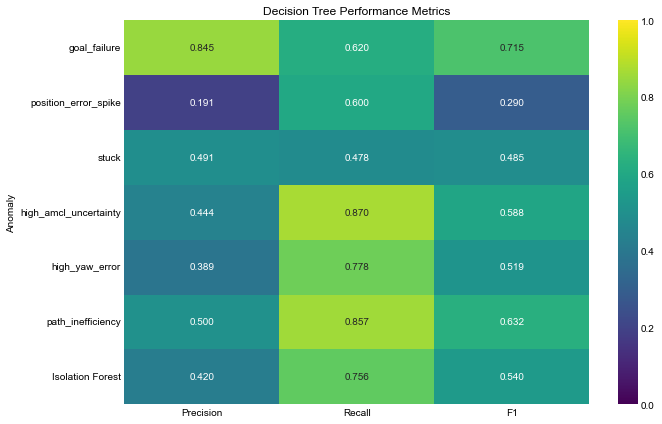

In [31]:
# Performance Summary
print('\n' + '='*70)
print('DECISION TREE PERFORMANCE SUMMARY')
print('='*70)

perf_df = pd.DataFrame([
    {'Anomaly': a, 'Precision': r['precision'], 'Recall': r['recall'], 
     'F1': r['f1'], 'Support': r['support']}
    for a, r in tree_reports.items()
])
print(perf_df.to_string(index=False))
print(f'\nMean F1: {perf_df["F1"].mean():.3f}')

# Visualization
if not perf_df.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(perf_df.set_index('Anomaly')[['Precision', 'Recall', 'F1']], 
                annot=True, fmt='.3f', cmap='viridis', vmin=0, vmax=1, ax=ax)
    ax.set_title('Decision Tree Performance Metrics')
    plt.tight_layout()
    plt.savefig(IMAGES_PATH / 'decision_tree_performance.png', dpi=150, **SAVEFIG_KW)
    plt.show()

## 10. Ensemble Model Anomaly Prediction 

### 10.1. Ensemble Model Architecture

In [32]:
class EnsembleAnomalyPredictor:
    """Ensemble-based anomaly prediction with multiple model comparison."""
    
    def __init__(self, feature_names: List[str]):
        self.feature_names = feature_names
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.feature_importance = None
        self.rule_thresholds = {}
        
    def _create_models(self, n_samples: int, n_positive: int):
        """Create model candidates with appropriate hyperparameters."""
        # Adjust parameters based on sample size
        min_samples = max(2, int(n_samples * 0.02))
        
        models = {
            'DecisionTree': DecisionTreeClassifier(
                max_depth=5, min_samples_leaf=min_samples, 
                min_samples_split=min_samples*2, class_weight='balanced', random_state=42
            ),
            'RandomForest': RandomForestClassifier(
                n_estimators=100, max_depth=6, min_samples_leaf=min_samples,
                class_weight='balanced', random_state=42, n_jobs=-1
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=100, max_depth=4, min_samples_leaf=min_samples,
                learning_rate=0.1, random_state=42
            )
        }
        
        return models
    
    def fit(self, X: np.ndarray, y: np.ndarray, cv_folds: int = 5):
        """Train multiple models and select the best one based on F1 score."""
        n_positive = sum(y)
        models = self._create_models(len(X), n_positive)
        
        best_f1 = -1
        results = {}
        
        cv = StratifiedKFold(n_splits=min(cv_folds, n_positive), shuffle=True, random_state=42)
        
        for name, model in models.items():
            try:
                # Cross-validation scores
                scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
                mean_f1 = scores.mean()
                std_f1 = scores.std()
                
                # Fit on full data
                model.fit(X, y)
                self.models[name] = model
                
                results[name] = {
                    'mean_f1': mean_f1, 'std_f1': std_f1,
                    'model': model
                }
                
                if mean_f1 > best_f1:
                    best_f1 = mean_f1
                    self.best_model = model
                    self.best_model_name = name
                    
            except Exception as e:
                print(f"    Warning: {name} failed - {e}")
                continue
        
        # Compute feature importance from best model
        self._compute_feature_importance(X, y)
        
        # Extract rule thresholds
        self._extract_rule_thresholds(X, y)
        
        return results
    
    def _compute_feature_importance(self, X: np.ndarray, y: np.ndarray):
        """Compute feature importance using multiple methods."""
        if self.best_model is None:
            return
        
        importance_scores = np.zeros(len(self.feature_names))
        
        # Method 1: Native feature importance (tree-based models)
        if hasattr(self.best_model, 'feature_importances_'):
            importance_scores += self.best_model.feature_importances_
        
        # Method 2: Permutation importance (works for all models)
        try:
            perm_imp = permutation_importance(
                self.best_model, X, y, n_repeats=10, random_state=42, n_jobs=-1
            )
            # Normalize and add
            perm_scores = perm_imp.importances_mean
            if perm_scores.max() > 0:
                perm_scores = perm_scores / perm_scores.max()
            importance_scores += perm_scores
        except Exception:
            pass
        
        # Normalize final scores
        if importance_scores.max() > 0:
            importance_scores = importance_scores / importance_scores.max()
        
        self.feature_importance = dict(zip(self.feature_names, importance_scores))
    
    def _extract_rule_thresholds(self, X: np.ndarray, y: np.ndarray):
        """Extract optimal thresholds for each important feature."""
        if self.feature_importance is None:
            return
        
        # Get top features
        sorted_features = sorted(self.feature_importance.items(), key=lambda x: -x[1])
        top_features = [f for f, imp in sorted_features if imp > 0.1][:10]
        
        for feat in top_features:
            feat_idx = self.feature_names.index(feat)
            feat_values = X[:, feat_idx]
            
            # Find optimal threshold using information gain
            best_threshold, best_gain = None, -1
            
            unique_vals = np.unique(feat_values)
            if len(unique_vals) <= 1:
                continue
                
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
            
            for thresh in thresholds[:50]:  # Limit to 50 candidates
                left_mask = feat_values <= thresh
                right_mask = ~left_mask
                
                if sum(left_mask) < 3 or sum(right_mask) < 3:
                    continue
                
                # Calculate information gain
                p_left = y[left_mask].mean() if sum(left_mask) > 0 else 0
                p_right = y[right_mask].mean() if sum(right_mask) > 0 else 0
                p_total = y.mean()
                
                # Use difference in class probability as proxy for gain
                gain = abs(p_left - p_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_threshold = thresh
            
            if best_threshold is not None:
                self.rule_thresholds[feat] = {
                    'threshold': best_threshold,
                    'direction': '>' if y[feat_values > best_threshold].mean() > y[feat_values <= best_threshold].mean() else '<=',
                    'gain': best_gain
                }
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict using the best model."""
        if self.best_model is None:
            return np.zeros(len(X))
        return self.best_model.predict(X)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict probabilities using the best model."""
        if self.best_model is None:
            return np.zeros((len(X), 2))
        if hasattr(self.best_model, 'predict_proba'):
            return self.best_model.predict_proba(X)
        else:
            preds = self.predict(X)
            return np.column_stack([1-preds, preds])
    
    def get_top_features(self, n: int = 5) -> List[Tuple[str, float]]:
        """Get top n most important features."""
        if self.feature_importance is None:
            return []
        return sorted(self.feature_importance.items(), key=lambda x: -x[1])[:n]



## 10.2 Ensemble Models Training

In [33]:
# Ensemble anomaly predictors per anomaly type
ensemble_predictors = {}
ensemble_reports = {}

for anom in ANOM_LABELS:
    y_anom = per_anomaly_labels[anom]
    n_positive = sum(y_anom)
    
    if n_positive < 5:
        print(f'\n{anom}: Skipped (only {n_positive} positive samples)')
        continue
    
    print(f'\n{anom} ({n_positive} positive samples):')
    print('-' * 40)
    
    predictor = EnsembleAnomalyPredictor(EXTRACTOR.FEATURE_NAMES)
    results = predictor.fit(X, y_anom)
    
    ensemble_predictors[anom] = predictor
    
    # Print model comparison
    for model_name, res in sorted(results.items(), key=lambda x: -x[1]['mean_f1']):
        marker = '★' if model_name == predictor.best_model_name else ' '
        print(f'  {marker} {model_name:20s}: F1={res["mean_f1"]:.3f} (±{res["std_f1"]:.3f})')
    
    # Store report
    y_pred = predictor.predict(X)
    p, r, f1, _ = precision_recall_fscore_support(y_anom, y_pred, average='binary', zero_division=0)
    ensemble_reports[anom] = {
        'best_model': predictor.best_model_name,
        'precision': p, 'recall': r, 'f1': f1, 'support': n_positive
    }




goal_failure (150 positive samples):
----------------------------------------
  ★ GradientBoosting    : F1=0.825 (±0.036)
    DecisionTree        : F1=0.747 (±0.039)
    RandomForest        : F1=0.745 (±0.042)

position_error_spike (15 positive samples):
----------------------------------------
  ★ GradientBoosting    : F1=0.650 (±0.245)
    RandomForest        : F1=0.466 (±0.110)
    DecisionTree        : F1=0.300 (±0.086)

stuck (115 positive samples):
----------------------------------------
  ★ GradientBoosting    : F1=0.521 (±0.100)
    RandomForest        : F1=0.505 (±0.053)
    DecisionTree        : F1=0.466 (±0.053)

high_amcl_uncertainty (23 positive samples):
----------------------------------------
  ★ GradientBoosting    : F1=0.775 (±0.153)
    RandomForest        : F1=0.764 (±0.153)
    DecisionTree        : F1=0.634 (±0.125)

high_yaw_error (9 positive samples):
----------------------------------------
  ★ RandomForest        : F1=0.700 (±0.163)
    GradientBoosting    :

# 11. Ensemble + Surrogate Tree Approach (current approach)

## 11.1 Surrogate Tree Rule Extractor

In [34]:
class SurrogateTreeExtractor:
    """Extract interpretable decision rules from ensemble predictor using surrogate tree."""
    def __init__(self, feature_names: List[str], max_depth: int = 4):
        self.feature_names = feature_names
        self.max_depth = max_depth
        self.surrogate_tree = None
        self.fidelity_score = None
        self.rules = []
        
        # Define which features are boolean for rule formatting
        self.bool_features = {
            'near_wall', 'at_door', 'door_too_narrow', 'in_narrow_corridor', 'in_small_room',
            'tight_clearance', 'in_corridor', 'goal_near_wall', 'goal_through_door',
            'waypoint_in_tight_space', 'high_noise', 'min_door_narrow',
            'near_static_obstacle', 'tight_obstacle_clearance', 'has_static_obstacles'
        }
    
    def fit(self, X: np.ndarray, ensemble_predictor: EnsembleAnomalyPredictor, 
            y_true: np.ndarray = None) -> dict:
        """Train surrogate tree on ensemble's predictions."""
        # Get ensemble predictions as "teacher labels"
        y_ensemble = ensemble_predictor.predict(X)
        
        # Train surrogate tree on ensemble predictions
        self.surrogate_tree = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_leaf=max(5, int(len(X) * 0.02)),
            min_samples_split=max(10, int(len(X) * 0.04)),
            class_weight='balanced',
            random_state=42
        )
        self.surrogate_tree.fit(X, y_ensemble)
        
        # Compute fidelity: how well surrogate mimics ensemble
        y_surrogate = self.surrogate_tree.predict(X)
        self.fidelity_score = accuracy_score(y_ensemble, y_surrogate)
        
        # Extract rules from surrogate tree
        self.rules = self._extract_rules()
        
        # Compute metrics
        metrics = {
            'fidelity': self.fidelity_score,
            'n_rules': len(self.rules),
            'tree_depth': self.surrogate_tree.get_depth(),
            'n_leaves': self.surrogate_tree.get_n_leaves()
        }
        
        # If true labels provided, compute generalization metrics
        if y_true is not None:
            p, r, f1, _ = precision_recall_fscore_support(
                y_true, y_surrogate, average='binary', zero_division=0
            )
            metrics.update({
                'precision': p,
                'recall': r,
                'f1': f1,
                'accuracy': accuracy_score(y_true, y_surrogate)
            })
        
        return metrics
    
    def _extract_rules(self) -> List[dict]:
        """Extract all decision rules from the surrogate tree."""
        tree_ = self.surrogate_tree.tree_
        feature_name = [self.feature_names[i] if i != -2 else 'undefined' 
                       for i in tree_.feature]
        rules = []
        
        def recurse(node, conditions, depth):
            if tree_.feature[node] != -2:  # Not a leaf
                name = feature_name[node]
                thresh = tree_.threshold[node]
                recurse(tree_.children_left[node], 
                       conditions + [(name, '<=', thresh)], depth + 1)
                recurse(tree_.children_right[node], 
                       conditions + [(name, '>', thresh)], depth + 1)
            else:  # Leaf node
                values = tree_.value[node].flatten()
                n_samples = tree_.n_node_samples[node]
                
                if len(values) >= 2:
                    prob_positive = values[1] / sum(values) if sum(values) > 0 else 0
                else:
                    prob_positive = 0.5
                
                if prob_positive >= 0.5 and n_samples >= 3:
                    rules.append({
                        'conditions': conditions,
                        'probability': prob_positive,
                        'support': n_samples,
                        'depth': depth,
                        'confidence': prob_positive
                    })
        
        recurse(0, [], 0)
        rules = sorted(rules, key=lambda x: (-x['confidence'], -x['support']))
        return rules
    
    def format_fol(self, rule: dict, class_name: str) -> str:
        """Format rule as First-Order Logic expression."""
        conditions = rule['conditions']
        formatted = []
        
        for feat, op, thresh in conditions:
            if feat in self.bool_features:
                if op == '>':
                    formatted.append(f'{feat}(t)')
                else:
                    formatted.append(f'¬{feat}(t)')
            else:
                formatted.append(f'{feat}(t) {op} {thresh:.3f}')
        
        if not formatted:
            return f'∀t : TRUE ⇒ {class_name}'
        
        return f'∀t : {" ∧ ".join(formatted)} ⇒ {class_name}'
    
    def format_natural_language(self, rule: dict, class_name: str) -> str:
        """Format rule as human-readable natural language."""
        conditions = rule['conditions']
        explanations = []
        
        for feat, op, thresh in conditions:
            feat_readable = feat.replace('_', ' ')
            
            if feat in self.bool_features:
                if op == '>':
                    explanations.append(f"robot is {feat_readable}")
                else:
                    explanations.append(f"robot is NOT {feat_readable}")
            else:
                if op == '>':
                    explanations.append(f"{feat_readable} > {thresh:.3f}")
                else:
                    explanations.append(f"{feat_readable} ≤ {thresh:.3f}")
        
        if not explanations:
            return f"Always predict {class_name}"
        
        return f"IF {' AND '.join(explanations)} THEN {class_name}"
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict using the surrogate tree."""
        if self.surrogate_tree is None:
            return np.zeros(len(X))
        return self.surrogate_tree.predict(X)
    
    def evaluate_rule_coverage(self, X: np.ndarray, y: np.ndarray, scenarios: List[str]) -> List[dict]:
        """Evaluate each rule's coverage, confusion counts, and scenario frequency."""
        evaluated_rules = []
        scen_arr = np.array(scenarios)
        total_scenarios = len(np.unique(scen_arr))
        
        for rule in self.rules:
            mask = np.ones(len(X), dtype=bool)
            for feat, op, thresh in rule['conditions']:
                feat_idx = self.feature_names.index(feat)
                if op == '>':
                    mask &= X[:, feat_idx] > thresh
                else:
                    mask &= X[:, feat_idx] <= thresh
            
            n_matches = sum(mask)
            if n_matches > 0:
                tp = int(np.sum((y == 1) & mask))
                fp = int(np.sum((y == 0) & mask))
                fn = int(np.sum((y == 1) & ~mask))
                tn = int(np.sum((y == 0) & ~mask))
                precision = tp / n_matches if n_matches > 0 else 0.0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
                coverage = n_matches / len(X)
                scen_hits = len(np.unique(scen_arr[mask]))
                scen_freq = scen_hits / total_scenarios if total_scenarios > 0 else 0.0
                
                evaluated_rules.append({
                    **rule,
                    'coverage': coverage,
                    'precision': precision,
                    'recall': recall,
                    'n_matches': n_matches,
                    'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                    'scenario_hits': scen_hits,
                    'scenario_frequency': scen_freq
                })
        
        return evaluated_rules

## 11.2 Train Surrogate Trees for Each Anomaly Type

In [35]:

surrogate_extractors = {}
surrogate_metrics = {}

for anom in ANOM_LABELS:
    if anom not in ensemble_predictors:
        continue
    
    y_anom = per_anomaly_labels[anom]
    n_positive = sum(y_anom)
    
    if n_positive < 5:
        print(f'\n{anom}: Skipped (only {n_positive} positive samples)')
        continue
    
    print(f'\n{anom} ({n_positive} positive samples):')
    print('-' * 40)
    
    surrogate = SurrogateTreeExtractor(EXTRACTOR.FEATURE_NAMES, max_depth=4)
    metrics = surrogate.fit(X, ensemble_predictors[anom], y_true=y_anom)
    
    surrogate_extractors[anom] = surrogate
    surrogate_metrics[anom] = metrics
    
    print(f'  Fidelity to ensemble: {metrics["fidelity"]:.3f}')
    print(f'  Tree depth: {metrics["tree_depth"]}, Leaves: {metrics["n_leaves"]}')
    if 'f1' in metrics:
        print(f'  Generalization F1: {metrics["f1"]:.3f} (P={metrics["precision"]:.3f}, R={metrics["recall"]:.3f})')
    print(f'  Extracted {metrics["n_rules"]} interpretable rules')


goal_failure (150 positive samples):
----------------------------------------
  Fidelity to ensemble: 0.840
  Tree depth: 4, Leaves: 11
  Generalization F1: 0.822 (P=0.925, R=0.740)
  Extracted 8 interpretable rules

position_error_spike (15 positive samples):
----------------------------------------
  Fidelity to ensemble: 0.857
  Tree depth: 4, Leaves: 5
  Generalization F1: 0.411 (P=0.259, R=1.000)
  Extracted 1 interpretable rules

stuck (115 positive samples):
----------------------------------------
  Fidelity to ensemble: 0.640
  Tree depth: 4, Leaves: 13
  Generalization F1: 0.652 (P=0.515, R=0.887)
  Extracted 5 interpretable rules

high_amcl_uncertainty (23 positive samples):
----------------------------------------
  Fidelity to ensemble: 0.973
  Tree depth: 4, Leaves: 7
  Generalization F1: 0.833 (P=0.800, R=0.870)
  Extracted 3 interpretable rules

high_yaw_error (9 positive samples):
----------------------------------------
  Fidelity to ensemble: 0.960
  Tree depth: 3, 

## 11.3 Surrogate Tree FOL Rules

In [36]:
# Display top rules per anomaly
all_surrogate_rules = {}

for anom, surrogate in surrogate_extractors.items():
    y_anom = per_anomaly_labels[anom]
    
    evaluated_rules = surrogate.evaluate_rule_coverage(X, y_anom, run_scenarios)
    all_surrogate_rules[anom] = evaluated_rules
    
    if evaluated_rules:
        metrics = surrogate_metrics[anom]
        print(f'\n{anom} (Fidelity={metrics["fidelity"]:.2f}, F1={metrics.get("f1", 0):.2f}):')
        
        for i, rule in enumerate(evaluated_rules[:3], 1):
            print(f'  Rule {i} (Cov={rule["coverage"]:.1%}, Prec={rule["precision"]:.2f}, Rec={rule["recall"]:.2f}, n={rule["n_matches"]}):')
            print(f'    Scenarios: {rule["scenario_hits"]} ({rule["scenario_frequency"]:.1%})')
            print(f'    Confusion: TP={rule["tp"]}, FP={rule["fp"]}, FN={rule["fn"]}, TN={rule["tn"]}')
            print(f'    FOL: {surrogate.format_fol(rule, anom)}')
            print(f'    NL:  {surrogate.format_natural_language(rule, anom)}')


goal_failure (Fidelity=0.84, F1=0.82):
  Rule 1 (Cov=17.0%, Prec=1.00, Rec=0.34, n=51):
    Scenarios: 20 (20.0%)
    Confusion: TP=51, FP=0, FN=99, TN=150
    FOL: ∀t : in_corridor(t) ∧ min_wall_distance(t) > 0.737 ∧ obstacle_clearance_ratio(t) <= 17.970 ⇒ goal_failure
    NL:  IF robot is in corridor AND min wall distance > 0.737 AND obstacle clearance ratio ≤ 17.970 THEN goal_failure
  Rule 2 (Cov=4.7%, Prec=1.00, Rec=0.09, n=14):
    Scenarios: 5 (5.0%)
    Confusion: TP=14, FP=0, FN=136, TN=150
    FOL: ∀t : ¬in_corridor(t) ∧ min_door_distance(t) <= 3.350 ∧ noise_level(t) > 0.030 ∧ ¬min_door_narrow(t) ⇒ goal_failure
    NL:  IF robot is NOT in corridor AND min door distance ≤ 3.350 AND noise level > 0.030 AND robot is NOT min door narrow THEN goal_failure
  Rule 3 (Cov=3.3%, Prec=1.00, Rec=0.07, n=10):
    Scenarios: 4 (4.0%)
    Confusion: TP=10, FP=0, FN=140, TN=150
    FOL: ∀t : in_corridor(t) ∧ min_wall_distance(t) > 0.737 ∧ obstacle_clearance_ratio(t) > 17.970 ∧ min_obstacle

## 11.4 Surrogate Tree Visualization

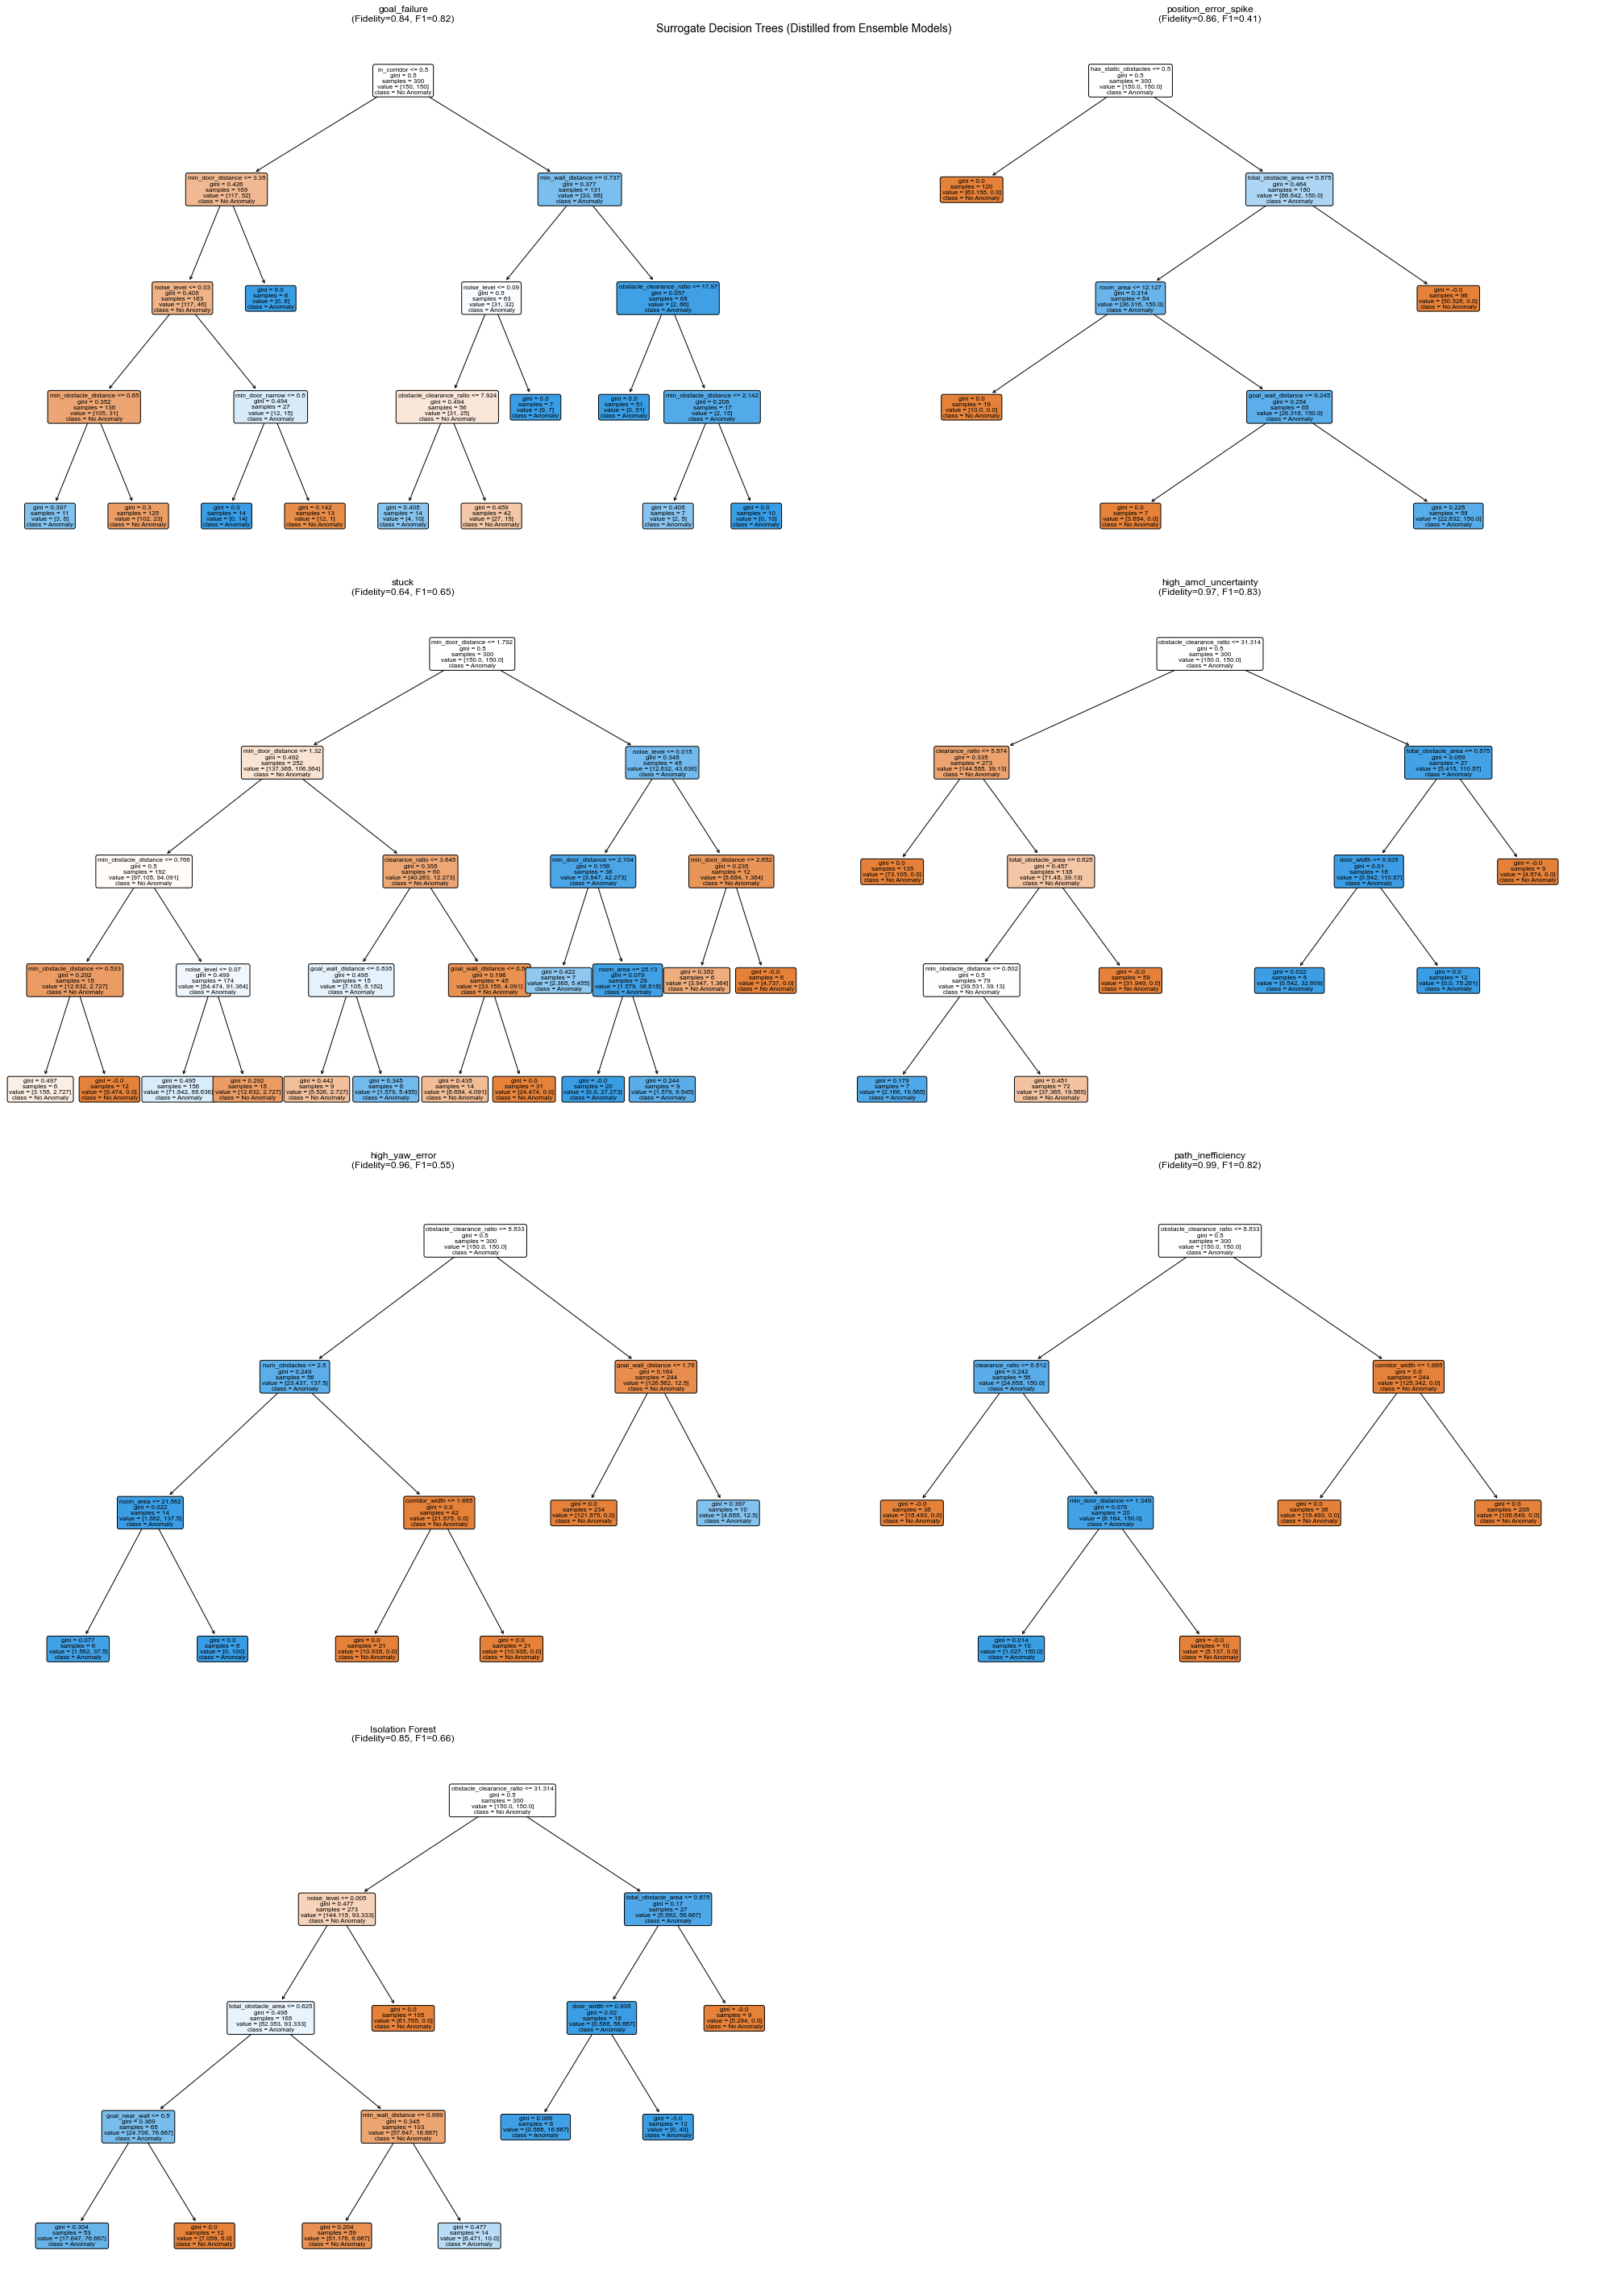

In [37]:
n_trees = len(surrogate_extractors)
if n_trees > 0:
    cols = min(2, n_trees)
    rows = (n_trees + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(14 * cols, 10 * rows))
    if n_trees == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for idx, (anom, surrogate) in enumerate(surrogate_extractors.items()):
        if idx >= len(axes):
            break
        ax = axes[idx]
        plot_tree(surrogate.surrogate_tree, 
                  feature_names=EXTRACTOR.FEATURE_NAMES,
                  class_names=['No Anomaly', 'Anomaly'],
                  filled=True, rounded=True, fontsize=8, ax=ax)
        metrics = surrogate_metrics[anom]
        ax.set_title(f'{anom}\n(Fidelity={metrics["fidelity"]:.2f}, F1={metrics.get("f1", 0):.2f})', 
                     fontsize=12)
    
    for idx in range(len(surrogate_extractors), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Surrogate Decision Trees (Distilled from Ensemble Models)', fontsize=14)
    plt.tight_layout()
    plt.savefig(IMAGES_PATH / 'surrogate_trees.png', dpi=150, bbox_inches='tight', **SAVEFIG_KW)
    plt.show()

## 11.5 Generalization Analysis


Surrogate Tree Performance Summary:
              Anomaly  Fidelity  Accuracy  Precision   Recall       F1  TP  FP  Rules
         goal_failure  0.840000  0.840000   0.925000 0.740000 0.822222 111   9      8
 position_error_spike  0.856667  0.856667   0.258621 1.000000 0.410959  15  43      1
                stuck  0.640000  0.636667   0.515152 0.886957 0.651757 102  96      5
high_amcl_uncertainty  0.973333  0.973333   0.800000 0.869565 0.833333  20   5      3
       high_yaw_error  0.960000  0.950000   0.375000 1.000000 0.545455   9  15      3
    path_inefficiency  0.993333  0.990000   0.700000 1.000000 0.823529   7   3      1
     Isolation Forest  0.853333  0.853333   0.505882 0.955556 0.661538  43  42      4

Mean Fidelity: 0.874
Mean F1: 0.678


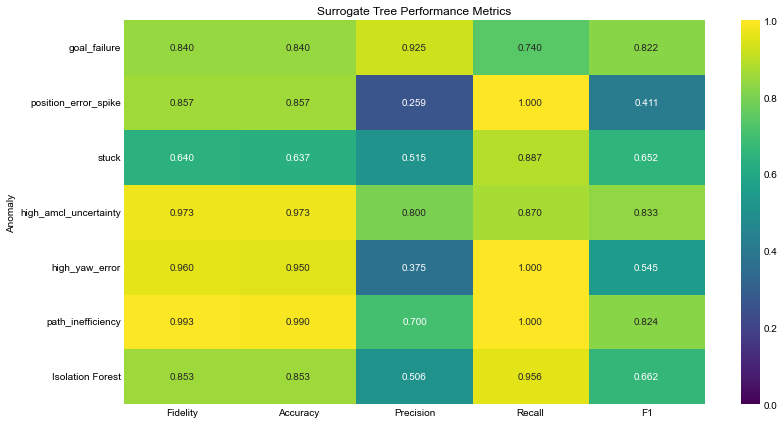

In [38]:

generalization_data = []

for anom, surrogate in surrogate_extractors.items():
    y_anom = per_anomaly_labels[anom]
    y_pred = surrogate.predict(X)
    
    tn, fp, fn, tp = confusion_matrix(y_anom, y_pred).ravel() if len(np.unique(y_anom)) > 1 else (0, 0, 0, 0)
    
    metrics = surrogate_metrics[anom]
    
    generalization_data.append({
        'Anomaly': anom,
        'Fidelity': metrics['fidelity'],
        'Accuracy': metrics.get('accuracy', 0),
        'Precision': metrics.get('precision', 0),
        'Recall': metrics.get('recall', 0),
        'F1': metrics.get('f1', 0),
        'TP': tp, 'FP': fp,
        'Rules': metrics['n_rules']
    })

generalization_df = pd.DataFrame(generalization_data)
print('\nSurrogate Tree Performance Summary:')
print(generalization_df.to_string(index=False))

print(f'\nMean Fidelity: {generalization_df["Fidelity"].mean():.3f}')
print(f'Mean F1: {generalization_df["F1"].mean():.3f}')

# Visualization
if not generalization_df.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    metrics_to_plot = ['Fidelity', 'Accuracy', 'Precision', 'Recall', 'F1']
    # Filter columns that exist in dataframe
    cols = [c for c in metrics_to_plot if c in generalization_df.columns]
    
    sns.heatmap(generalization_df.set_index('Anomaly')[cols], 
                annot=True, fmt='.3f', cmap='viridis', vmin=0, vmax=1, ax=ax)
    ax.set_title('Surrogate Tree Performance Metrics')
    plt.tight_layout()
    plt.savefig(IMAGES_PATH / 'surrogate_tree_performance.png', dpi=150, **SAVEFIG_KW)
    plt.show()

### 10.6. Feature Importance Heatmap (Ensemble + Surrogate Models)

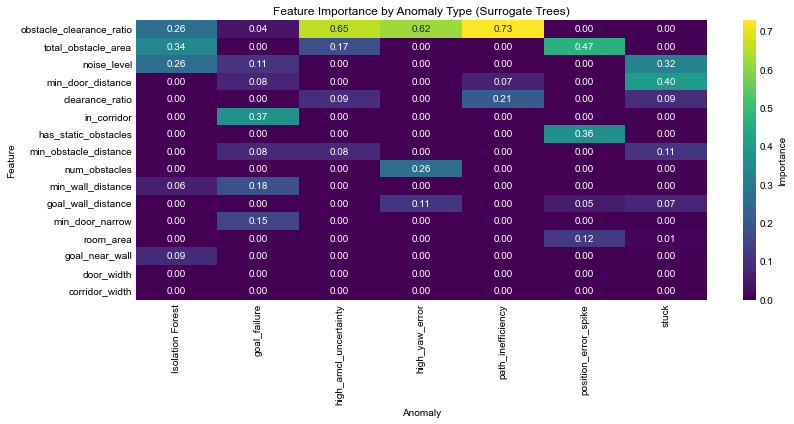

In [39]:
# Feature importance from surrogate trees
importance_data = []

for anom, surrogate in surrogate_extractors.items():
    if surrogate.surrogate_tree:
        imps = surrogate.surrogate_tree.feature_importances_
        for name, imp in zip(EXTRACTOR.FEATURE_NAMES, imps):
            if imp > 0:
                importance_data.append({
                    'Anomaly': anom,
                    'Feature': name,
                    'Importance': imp
                })

if importance_data:
    imp_df = pd.DataFrame(importance_data)
    
    # Pivot for heatmap
    pivot_df = imp_df.pivot_table(index='Feature', columns='Anomaly', values='Importance', fill_value=0)
    
    # Sort by total importance
    pivot_df['Total'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('Total', ascending=False).drop(columns='Total')
    
    # Plot
    plt.figure(figsize=(12, max(6, len(pivot_df) * 0.3)))
    sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Importance'})
    plt.title('Feature Importance by Anomaly Type (Surrogate Trees)')
    plt.tight_layout()
    plt.savefig(IMAGES_PATH / 'surrogate_feature_importance.png', dpi=150, **SAVEFIG_KW)
    plt.show()
else:
    print("No feature importance data available.")

## 11.7 Model Comparison: Baseline DT vs Ensemble vs Surrogate


MODEL COMPARISON: Baseline DT vs Ensemble vs Surrogate Tree
              Anomaly    DT_F1   Ens_F1  Surr_F1  Fidelity
         goal_failure 0.715385 1.000000 0.822222  0.840000
 position_error_spike 0.290323 1.000000 0.410959  0.856667
                stuck 0.484581 0.977778 0.651757  0.640000
high_amcl_uncertainty 0.588235 1.000000 0.833333  0.973333
       high_yaw_error 0.518519 0.857143 0.545455  0.960000
    path_inefficiency 0.631579 0.933333 0.823529  0.993333
     Isolation Forest 0.539683 1.000000 0.661538  0.853333


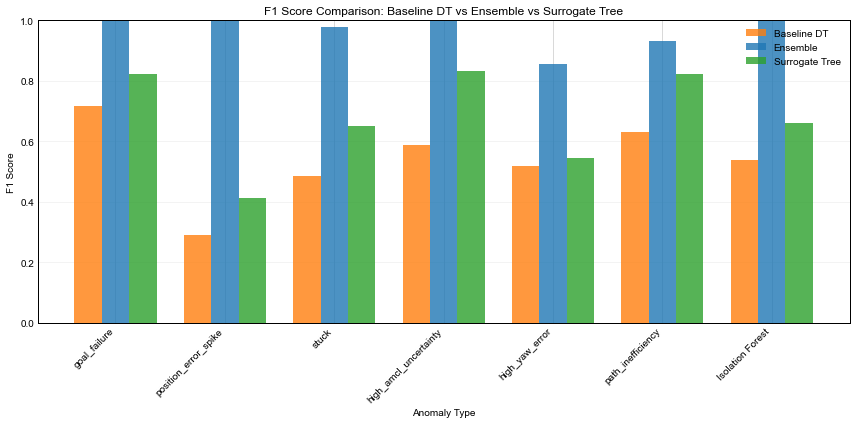

In [ ]:
# Comparison of Decision Tree, Ensemble, and Surrogate Tree F1 scores
comparison_data = []

for anom in ANOM_LABELS:
    row = {'Anomaly': anom}
    
    if anom in tree_reports:
        row['DT_F1'] = tree_reports[anom]['f1']
    else:
        row['DT_F1'] = 0
    
    if anom in ensemble_reports:
        row['Ens_F1'] = ensemble_reports[anom]['f1']
    else:
        row['Ens_F1'] = 0
    
    if anom in surrogate_metrics:
        row['Surr_F1'] = surrogate_metrics[anom].get('f1', 0)
        row['Fidelity'] = surrogate_metrics[anom]['fidelity']
    else:
        row['Surr_F1'] = row['Fidelity'] = 0
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# F1 comparison visualization
if not comparison_df.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.25
    
    ax.bar(x - width, comparison_df['DT_F1'], width, label='Baseline DT', color='#ff7f0e', alpha=0.8)
    ax.bar(x, comparison_df['Ens_F1'], width, label='Ensemble', color='#1f77b4', alpha=0.8)
    ax.bar(x + width, comparison_df['Surr_F1'], width, label='Surrogate Tree', color='#2ca02c', alpha=0.8)
    
    ax.set_xlabel('Anomaly Type')
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Score Comparison: Baseline DT vs Ensemble vs Surrogate Tree')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Anomaly'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(IMAGES_PATH / 'model_comparison_f1.png', dpi=150, **SAVEFIG_KW)
    plt.show()